In [1]:
import json
import os
import rdflib
from rdflib import ConjunctiveGraph, Graph, URIRef, Literal, Namespace
from rdflib.namespace import SKOS, DCTERMS, RDF

from openai import OpenAI
from langchain.chains import GraphSparqlQAChain
from langchain_community.graphs import RdfGraph
from langchain_openai import ChatOpenAI

import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
import networkx as nx
from pyvis.network import Network

import requests
import xml.etree.ElementTree as ET
from html.parser import HTMLParser
from html import unescape
import re
from keybert import KeyBERT

In [3]:
# Opening config file -> this config file is found in a config folder, the config structure is:
# {"access_token_zenodo":"......"
# "openai_api_key":"......"}

config = open('config.json', 'r')
config = json.load(config)

os.environ['OPENAI_API_KEY'] = config['openai_api_key']

### A simple example of converting text to RDF statements

In [5]:
# Raw texts from the report
raw_text = "Soil: is the top terrestrial layer of the Earth; is composed of a mixture of mineral and organic compounds, water, air and living organisms; is one of the most complex biomaterials on earth (Young and Crawford, 2004); provides multiple functions that support the delivery of ecosystem services, including the life support function;varies naturally in both space and time over a range of scales."

In [7]:
# Refenence from the report
raw_ref = "Young, I. and Crawford, J., 2004, ‘Interactions and Self-Organization in the Soil-Microbe Complex’, Science (New York, N.Y.) 304 (1634-7. 10.1126/science.1097394)."

In [282]:
# "Ground-truth" RDF statements linked to AGROVOC
rdf_data = """
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .

ex:Soil a skos:Concept;
    skos:prefLabel "Soil";
    skos:definition "The top terrestrial layer of the Earth.";
    skos:note "Soil is composed of a mixture of mineral and organic compounds, water, air, and living organisms.";
    skos:note "Soil is one of the most complex biomaterials on earth.";
    dc:isReferencedBy ex:YoungCrawford2004;
    skos:exactMatch agrovoc:c_7156.

ex:SoilFunctions a skos:Concept;
    skos:prefLabel "Soil Functions";
    skos:note "Soil provides multiple functions that support the delivery of ecosystem services, including life support functions.";
    skos:exactMatch agrovoc:c_e5629cbd.

ex:SoilVariability a skos:Concept;
    skos:prefLabel "Soil Variability";
    skos:note "Soil varies naturally in both space and time over a range of scales.".

ex:YoungCrawford2004 a dc:BibliographicResource ;
	    dc:title "Interactions and Self-Organization in the Soil-Microbe Complex" ;
	    dc:creator "Young, I.", "Crawford, J.";
	    dc:date "2004" ;
	    dc:isPartOf "Science (New York, N.Y.)" ;
	    dc:identifier "10.1126/science.1097394" ;
	    dc:publisher "American Association for the Advancement of Science" ;
	    dc:extent "Pages 1634-7" .
"""

In [284]:
# "Ground-truth" RDF statements
rdf_data_gt = """
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/> .

ex:Soil a skos:Concept;
    skos:prefLabel "Soil";
    skos:definition "The top terrestrial layer of the Earth.";
    skos:note "Soil is composed of a mixture of mineral and organic compounds, water, air, and living organisms.";
    skos:note "Soil is one of the most complex biomaterials on earth.";
    dc:isReferencedBy ex:YoungCrawford2004;

ex:SoilFunctions a skos:Concept;
    skos:prefLabel "Soil Functions";
    skos:note "Soil provides multiple functions that support the delivery of ecosystem services, including life support functions.";

ex:SoilVariability a skos:Concept;
    skos:prefLabel "Soil Variability";
    skos:note "Soil varies naturally in both space and time over a range of scales.".

ex:YoungCrawford2004 a dc:BibliographicResource ;
	    dc:title "Interactions and Self-Organization in the Soil-Microbe Complex" ;
	    dc:creator "Young, I.", "Crawford, J.";
	    dc:date "2004" ;
	    dc:isPartOf "Science (New York, N.Y.)" ;
	    dc:identifier "10.1126/science.1097394" ;
	    dc:publisher "American Association for the Advancement of Science" ;
	    dc:extent "Pages 1634-7" .
"""

In [286]:
# Create a Graph
g = rdflib.Graph()

g.parse(data=rdf_data, format='turtle')
for s, p, o in g:
    print(s, p, o)

http://example.org/Soil http://www.w3.org/2004/02/skos/core#note Soil is composed of a mixture of mineral and organic compounds, water, air, and living organisms.
http://example.org/SoilVariability http://www.w3.org/2004/02/skos/core#prefLabel Soil Variability
http://example.org/Soil http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://example.org/YoungCrawford2004 http://purl.org/dc/terms/identifier 10.1126/science.1097394
http://example.org/Soil http://purl.org/dc/terms/isReferencedBy http://example.org/YoungCrawford2004
http://example.org/SoilVariability http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://example.org/YoungCrawford2004 http://purl.org/dc/terms/isPartOf Science (New York, N.Y.)
http://example.org/YoungCrawford2004 http://purl.org/dc/terms/extent Pages 1634-7
http://example.org/SoilFunctions http://www.w3.org/2004/02/skos/core#prefLabel Soil Functions
http://example.org/YoungCr


(process:20320): Pango-WARNING **: 16:23:05.624: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:20320): Pango-WARNING **: 16:23:05.628: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:20320): Pango-WARNING **: 16:23:05.631: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



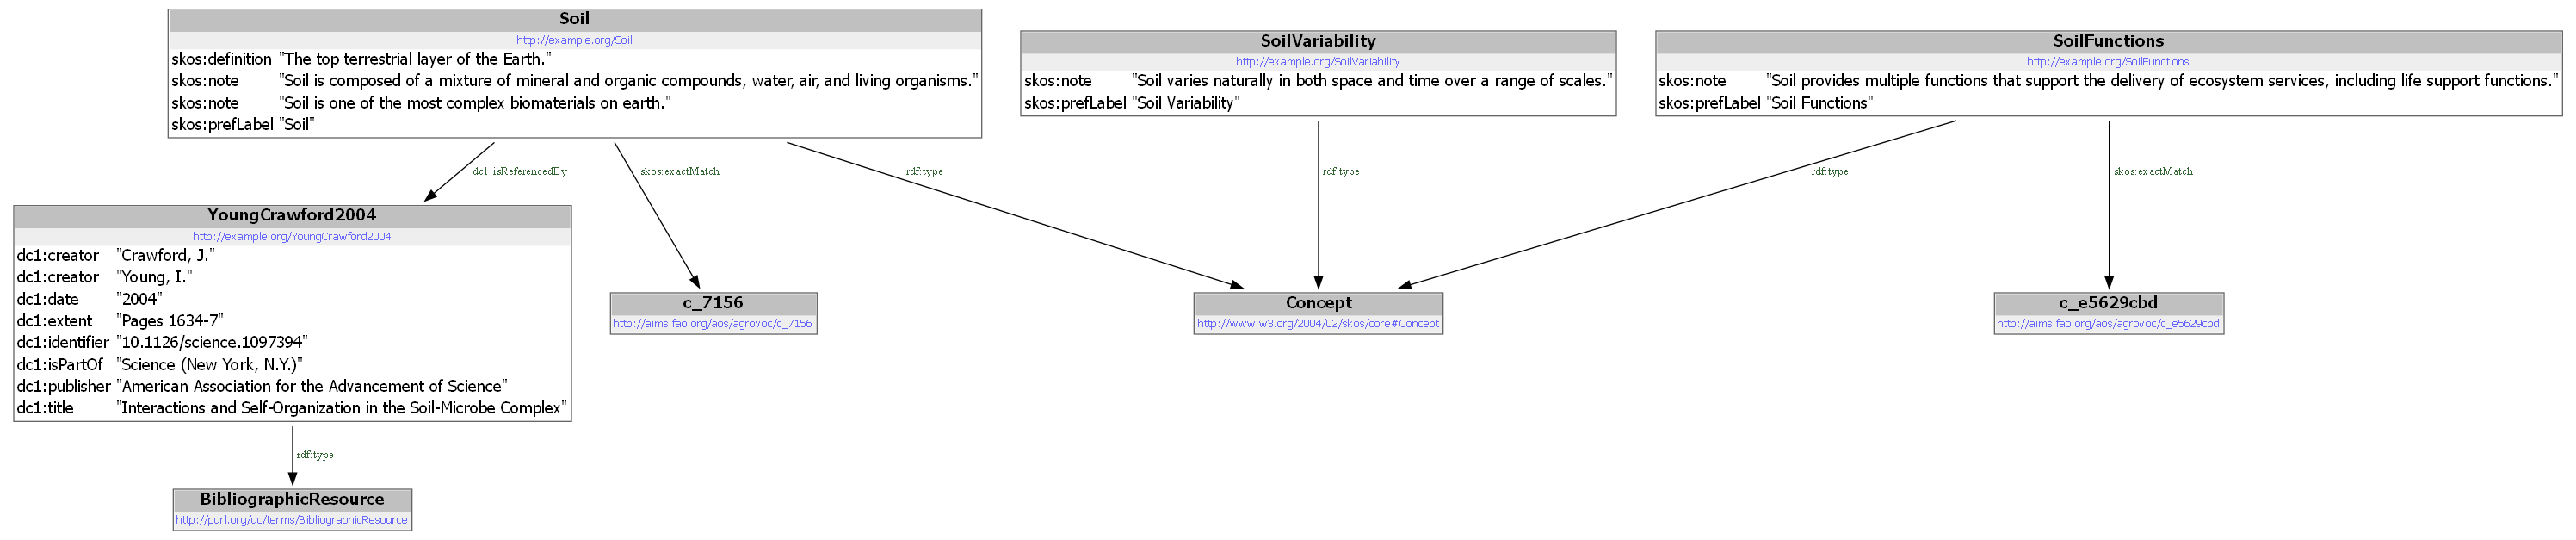

In [288]:
# Visualize the graph
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)

In [290]:
# Alternative approach to visualize the graph
G = nx.DiGraph()  # Directed graph, since RDF relationships are directional

def extract_label(resource):
    if isinstance(resource, rdflib.URIRef):
        # Check if the URIRef is meant to be a readable identifier (like a URL)
        if resource.startswith("https"):
            return str(resource)  # Return full URL for identifiers
        elif '#' in resource:
            return resource.split('#')[-1]  # For URIs with fragment identifiers
        else:
            return resource.split('/')[-1]  # For URIs without fragment identifiers
    elif isinstance(resource, rdflib.Literal):
        return str(resource)  # Return the literal value directly
    else:
        return str(resource)  # Fallback for other types

for subj, pred, obj in g:
    subj_label = extract_label(subj)
    pred_label = extract_label(pred)
    obj_label = extract_label(obj)

    # Add nodes and edges with appropriate labels
    G.add_node(subj_label, label=subj_label)
    G.add_node(obj_label, label=obj_label)
    G.add_edge(subj_label, obj_label, label=pred_label)

print("Graph has %s nodes and %s edges" % (G.number_of_nodes(), G.number_of_edges()))

net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True)
# Load the networkx graph
net.from_nx(G)

net.show("rdf_graph.html")

Graph has 23 nodes and 23 edges
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [292]:
# This query will return all nodes in the graph that are categorized as skos:Concept.

query = """
SELECT ?concept ?label
WHERE {
  ?concept a skos:Concept ;
           skos:prefLabel ?label .
}
"""

# Execute the query
for row in g.query(query):
    print(f"Concept: {row.concept}, Label: {row.label}")

Concept: http://example.org/Soil, Label: Soil
Concept: http://example.org/SoilFunctions, Label: Soil Functions
Concept: http://example.org/SoilVariability, Label: Soil Variability


In [294]:
# Retrieve all properties and notes associated with the "Soil" concept.

query = """
SELECT ?property ?value
WHERE {
  ex:Soil ?property ?value .
}
"""

# Execute the query
for row in g.query(query):
    print(f"Property: {row.property}, Value: {row.value}")

Property: http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Value: http://www.w3.org/2004/02/skos/core#Concept
Property: http://www.w3.org/2004/02/skos/core#prefLabel, Value: Soil
Property: http://www.w3.org/2004/02/skos/core#definition, Value: The top terrestrial layer of the Earth.
Property: http://www.w3.org/2004/02/skos/core#note, Value: Soil is composed of a mixture of mineral and organic compounds, water, air, and living organisms.
Property: http://www.w3.org/2004/02/skos/core#note, Value: Soil is one of the most complex biomaterials on earth.
Property: http://purl.org/dc/terms/isReferencedBy, Value: http://example.org/YoungCrawford2004
Property: http://www.w3.org/2004/02/skos/core#exactMatch, Value: http://aims.fao.org/aos/agrovoc/c_7156


In [296]:
# Search for all concepts where the note contains the word "soil"

query = """
SELECT ?concept ?note
WHERE {
  ?concept skos:note ?note
  FILTER CONTAINS(LCASE(str(?note)), "soil")
}
"""

# Execute the query
for row in g.query(query):
    print(f"Concept: {row.concept}, Note: {row.note}")

Concept: http://example.org/Soil, Note: Soil is composed of a mixture of mineral and organic compounds, water, air, and living organisms.
Concept: http://example.org/Soil, Note: Soil is one of the most complex biomaterials on earth.
Concept: http://example.org/SoilFunctions, Note: Soil provides multiple functions that support the delivery of ecosystem services, including life support functions.
Concept: http://example.org/SoilVariability, Note: Soil varies naturally in both space and time over a range of scales.


In [298]:
# Extract bibliographic information for references cited within the knowledge graph

query = """
PREFIX dc: <http://purl.org/dc/terms/>

SELECT ?resource ?title (GROUP_CONCAT(?creator; separator=", ") AS ?creators) ?date ?identifier
WHERE {
  ?resource a dc:BibliographicResource ;
            dc:title ?title ;
            dc:creator ?creator ;
            dc:date ?date ;
            dc:identifier ?identifier .
}
GROUP BY ?resource ?title ?date ?identifier
"""

# Execute the query
for row in g.query(query):
    print(f"Resource: {row.resource}, Title: {row.title}, Creators: {row.creators}, Date: {row.date}, Identifier: {row.identifier}")

Resource: http://example.org/YoungCrawford2004, Title: Interactions and Self-Organization in the Soil-Microbe Complex, Creators: Young, I., Crawford, J., Date: 2004, Identifier: 10.1126/science.1097394


### Convert text to RDF statements with LLMs: a zero-shot example

In [175]:
raw_text_llm = "In order to manage soil sustainably, and protect it where necessary, knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions. Healthy soils deliver ecosystem services to the best of their capacity. Unquestionable evidence shows that land cultivation and urbanisation have altered many soil properties, causing reduced soil functioning (JRC, 2012; EC, 2020a). Such soils are then degraded, which consequently harms ecosystems and their life support functions. In the case of soil sealing, soil functions are largely and irreversibly lost."

In [177]:
raw_ref_llm_1 = "JRC, 2012, The state of soil in Europe, Joint Research Centre (https://publications.jrc.ec.europa.eu/repository/bitstream/JRC68418/lbna25186enn.pdf) accessed 26 November 2020."

In [179]:
raw_ref_llm_2 = "EC, 2020a, Caring for soil is caring for life, European Commission (https://op.europa.eu/en/web/eu-law-and-publications/publication-detail/-/publication/32d5d312-b689-11ea-bb7a-01aa75ed71a1) accessed 26 November 2020."

In [139]:
# Prompt for zero-shot learning
prompt_0 = f"""
Please help me convert this text to an RDF knowledge graph using only the combination of SKOS Core and Dublin Core as ontologies and 'ex' as a prefix:
'{raw_text_llm}'
And here is the bibliographic information for the reference(s) cited in this text:
'{raw_ref_llm_1}'
And:
'{raw_ref_llm_2}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph in Turtle format without any comments. Thank you!
"""

In [143]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user",
     "content": prompt_0
    }
  ]
)

print(completion.choices[0].message.content)

```ttl
@prefix ex: <http://example.org/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

ex:SoilSustainability a skos:Concept ;
    skos:prefLabel "Soil Sustainability" ;
    dcterms:description "In order to manage soil sustainably, and protect it where necessary, knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions. Healthy soils deliver ecosystem services to the best of their capacity." .

ex:SoilDegradation a skos:Concept ;
    skos:prefLabel "Soil Degradation" ;
    dcterms:description "Unquestionable evidence shows that land cultivation and urbanisation have altered many soil properties, causing reduced soil functioning. Such soils are then degraded, which consequently harms ecosystems and their life support functions." ;
    dcterms:source ex:JRC2012, ex:EC2020a .

ex:SoilSealing a skos:Concept ;
    skos:prefLabel "Soil Sealing" ;
    dcterms:descriptio

In [147]:
rdf_data_llm_0 = completion.choices[0].message.content.replace('```ttl\n', '')
rdf_data_llm_0 = rdf_data_llm_0.replace('\n```', '') 

# Create a Graph
g_0 = rdflib.Graph()

g_0.parse(data=rdf_data_llm_0, format='turtle')
for s, p, o in g_0:
    print(s, p, o)

http://example.org/SoilSustainability http://purl.org/dc/terms/description In order to manage soil sustainably, and protect it where necessary, knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions. Healthy soils deliver ecosystem services to the best of their capacity.
http://example.org/SoilDegradation http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://example.org/JRC2012 http://purl.org/dc/terms/creator Joint Research Centre
http://example.org/SoilSealing http://www.w3.org/2004/02/skos/core#prefLabel Soil Sealing
http://example.org/EC2020a http://purl.org/dc/terms/accessRights accessed 26 November 2020
http://example.org/SoilSustainability http://www.w3.org/2004/02/skos/core#prefLabel Soil Sustainability
http://example.org/JRC2012 http://purl.org/dc/terms/title The state of soil in Europe
http://example.org/SoilDegradation http://purl.org/dc/terms/description Unquest


(process:21144): Pango-WARNING **: 14:06:14.788: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:21144): Pango-WARNING **: 14:06:14.805: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:21144): Pango-WARNING **: 14:06:14.809: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



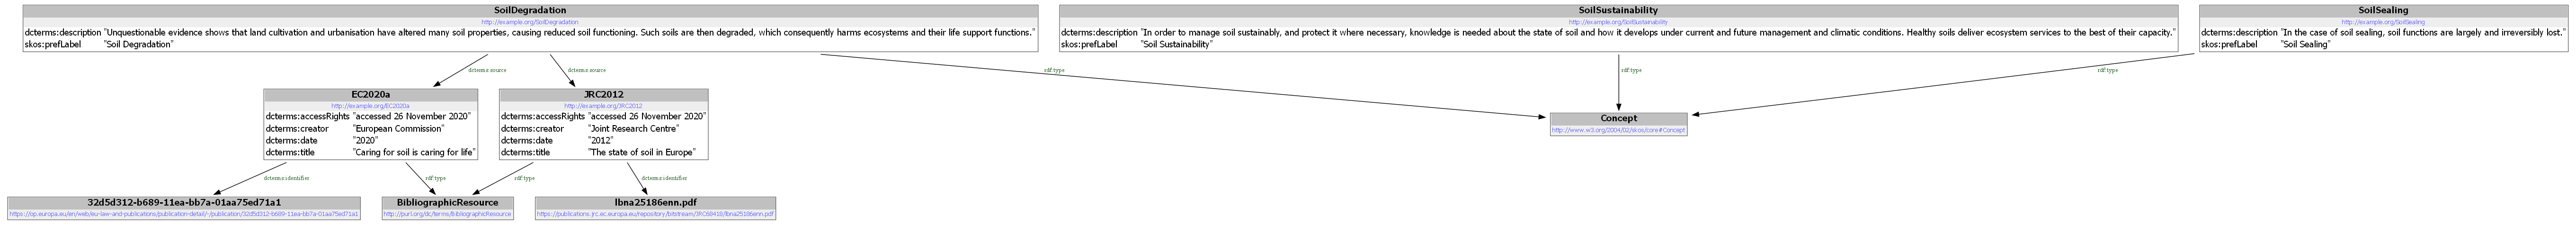

In [149]:
visualize(g_0)

### A few-shot (one-shot) example

In [322]:
# Prompt for one-shot learning
prompt_1 = f"""
Now I will show an example of how to convert text to an RDF knowledge graph using only the combination of SKOS Core and Dublin Core as ontologies. Here is the raw text:
'{raw_text}'
And here is the bibliographic information for the reference(s) cited in this text:
'{raw_ref}'
This is the ground-truth RDF knowledge graph for this text:
'{rdf_data_p}'
Follow this example, please help me convert the following text to an RDF knowledge graph, also using only the combination of SKOS Core and Dublin Core as ontologies and 'ex' as a prefix:
'{raw_text_llm}'
And here is the bibliographic information for the reference(s) cited in this text:
'{raw_ref_llm_1}'
And:
'{raw_ref_llm_2}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph in Turtle format without any comments. Thank you!
"""

In [326]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user",
     "content": prompt_1
    }
  ]
)

print(completion.choices[0].message.content)

```turtle
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/> .

ex:SoilManagement a skos:Concept;
    skos:prefLabel "Soil Management";
    skos:note "Knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions to manage soil sustainably and protect it where necessary.".

ex:HealthySoils a skos:Concept;
    skos:prefLabel "Healthy Soils";
    skos:note "Healthy soils deliver ecosystem services to the best of their capacity.".

ex:SoilDegradation a skos:Concept;
    skos:prefLabel "Soil Degradation";
    skos:note "Land cultivation and urbanisation have altered many soil properties, causing reduced soil functioning.";
    skos:note "Degraded soils harm ecosystems and their life support functions.";
    dc:isReferencedBy ex:JRC2012, ex:EC2020a.

ex:SoilSealing a skos:Concept;
    skos:prefLabel "Soil Sealing";
    skos:note "In the case of soil s

In [314]:
rdf_data_llm_gt = """
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .

ex:SoilManagement a skos:Concept;
    skos:prefLabel "Soil Management";
    skos:note "Managing soil sustainably and protecting it where necessary.";
    skos:note "Knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions.";
    skos:exactMatch agrovoc:c_7176.

ex:SoilHealth a skos:Concept;
    skos:prefLabel "Soil Health";
    skos:definition "Healthy soils deliver ecosystem services to the best of their capacity.";
    skos:closeMatch agrovoc:c_a9645d28.

ex:SoilFunctions a skos:Concept;
    skos:prefLabel "Soil Functions";
    skos:note "Land cultivation and urbanisation have altered many soil properties, causing reduced soil functioning.";
    dc:isReferencedBy ex:JRC2012, ex:EC2020a;
    skos:exactMatch agrovoc:c_e5629cbd.

ex:SoilDegradation a skos:Concept;
    skos:prefLabel "Soil Degradation";
    skos:definition "Reducing soil function";
    skos:note "Degraded soils harm ecosystems and their life support functions";
    skos:exactMatch agrovoc:c_7168.

ex:SoilSealing a skos:Concept;
    skos:prefLabel "Soil Sealing";
    skos:note "Soil sealing causes the largely and irreversible loss of soil functions.";
    skos:broader ex:SoilDegradation;
    skos:exactMatch agrovoc:c_f9554e7c.

ex:JRC2012 a dc:BibliographicResource;
    dc:title "The state of soil in Europe";
    dc:creator "Joint Research Centre";
    dc:date "2012";
    dc:identifier "https://publications.jrc.ec.europa.eu/repository/bitstream/JRC68418/lbna25186enn.pdf".

ex:EC2020a a dc:BibliographicResource;
    dc:title "Caring for soil is caring for life";
    dc:creator "European Commission";
    dc:date "2020";
    dc:identifier "https://op.europa.eu/en/web/eu-law-and-publications/publication-detail/-/publication/32d5d312-b689-11ea-bb7a-01aa75ed71a1".
"""

In [330]:
rdf_data_llm_1 = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_1 = rdf_data_llm_1.replace('\n```', '') 

# Create a Graph
g_1 = rdflib.Graph()

g_1.parse(data=rdf_data_llm_gt, format='turtle')
for s, p, o in g_1:
    print(s, p, o)

http://example.org/SoilManagement http://www.w3.org/2004/02/skos/core#exactMatch http://aims.fao.org/aos/agrovoc/c_7176
http://example.org/SoilDegradation http://www.w3.org/2004/02/skos/core#note Degraded soils harm ecosystems and their life support functions
http://example.org/SoilDegradation http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://example.org/JRC2012 http://purl.org/dc/terms/title The state of soil in Europe
http://example.org/EC2020a http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://purl.org/dc/terms/BibliographicResource
http://example.org/SoilHealth http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://example.org/SoilFunctions http://www.w3.org/2004/02/skos/core#exactMatch http://aims.fao.org/aos/agrovoc/c_e5629cbd
http://example.org/JRC2012 http://purl.org/dc/terms/date 2012
http://example.org/SoilSealing http://www.w3.org/2004/02/skos/core#note Soil sealing causes the la


(process:18896): Pango-WARNING **: 16:49:03.652: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:18896): Pango-WARNING **: 16:49:03.663: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:18896): Pango-WARNING **: 16:49:03.664: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



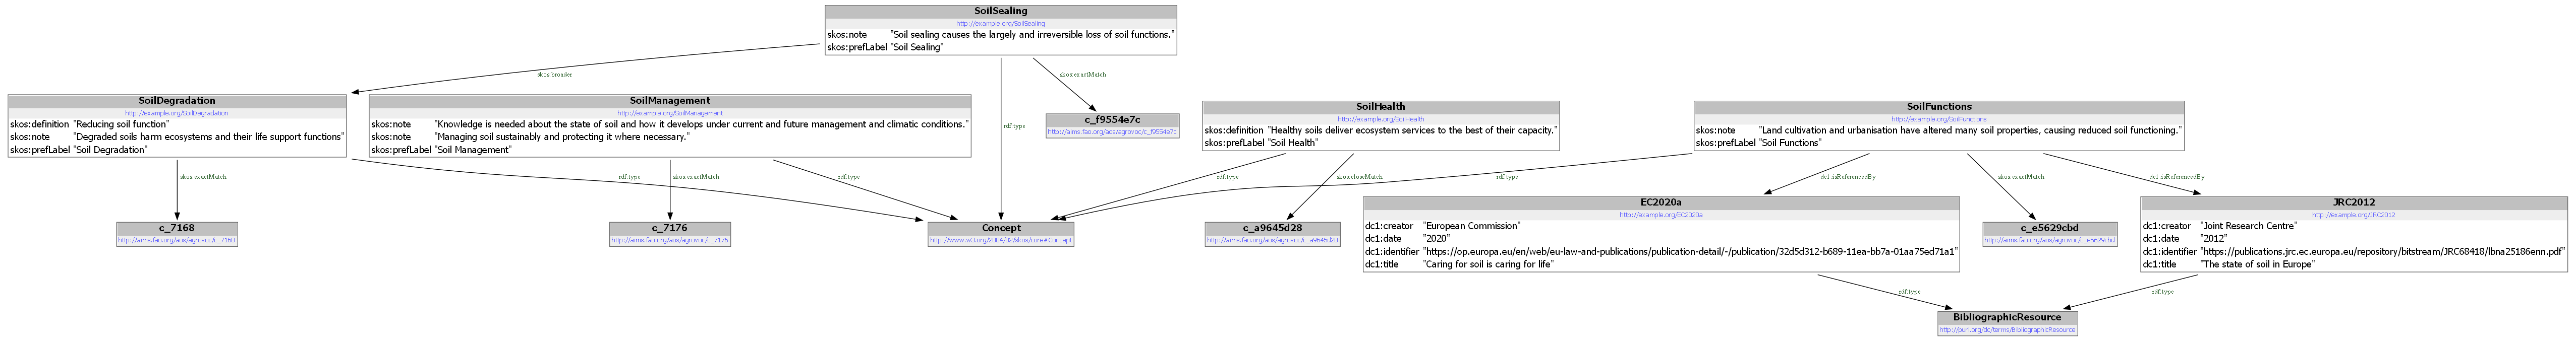

In [334]:
visualize(g_1)

### Evaluate different strategies

In [336]:
#Exact Match Precision, Recall and F1 
def compute_metrics(ground_truth_triples, generated_triples):
    true_positives = set(ground_truth_triples) & set(generated_triples)
    false_positives = set(generated_triples) - set(ground_truth_triples)
    false_negatives = set(ground_truth_triples) - set(generated_triples)

    precision = len(true_positives) / len(generated_triples) if generated_triples else 0
    recall = len(true_positives) / len(ground_truth_triples) if ground_truth_triples else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1_score

In [338]:
# Regular Precision, Recall and F1 score
def compute_partial_metrics(gt_triples, gen_triples):
    # Dictionary to count matches for subjects, predicates, and objects
    matched_gt_indices = {
        'subject': set(),
        'predicate': set(),
        'object': set()
    }

    # Convert triples to lists to index them
    gt_triples_list = list(gt_triples)
    gen_triples_list = list(gen_triples)

    # Count matches
    match_counts = {'subject': 0, 'predicate': 0, 'object': 0}

    # Iterate over generated triples
    for idx_gen, (gen_s, gen_p, gen_o) in enumerate(gen_triples_list):
        # Iterate over ground truth triples
        for idx_gt, (gt_s, gt_p, gt_o) in enumerate(gt_triples_list):
            if gen_s == gt_s and idx_gt not in matched_gt_indices['subject']:
                match_counts['subject'] += 1
                matched_gt_indices['subject'].add(idx_gt)
            if gen_p == gt_p and idx_gt not in matched_gt_indices['predicate']:
                match_counts['predicate'] += 1
                matched_gt_indices['predicate'].add(idx_gt)
            if gen_o == gt_o and idx_gt not in matched_gt_indices['object']:
                match_counts['object'] += 1
                matched_gt_indices['object'].add(idx_gt)

    # Total potential matches are three times the count of generated triples
    total_possible = len(gen_triples) * 3
    total_matches = sum(match_counts.values())
    total_gt_possible = len(gt_triples) * 3

    # Calculate precision and recall
    precision = total_matches / total_possible if total_possible else 0
    recall = total_matches / total_gt_possible if total_gt_possible else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1_score

In [415]:
def load_graph(data):
    g = rdflib.Graph()
    g.parse(data=data, format="turtle")
    return g

#Results of zero-shot
precision, recall, f1_score = compute_metrics(set(g_1), set(g_0))

print(f"Precision (EM): {precision:.4f}")
print(f"Recall (EM): {recall:.4f}")
print(f"F1 Score (EM): {f1_score:.4f}")

Precision (EM): 0.5217
Recall (EM): 0.2182
F1 Score (EM): 0.3077


In [409]:
#Results of zero-shot
precision, recall, f1_score = compute_partial_metrics(set(g_1), set(g_0))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 1.0145
Recall: 0.4242
F1 Score: 0.5983


In [411]:
#Results of one-shot
precision, recall, f1_score = compute_metrics(set(g_1), set(load_graph(rdf_data_llm_1)))

print(f"Precision (EM): {precision:.4f}")
print(f"Recall (EM): {recall:.4f}")
print(f"F1 Score (EM): {f1_score:.4f}")

Precision (EM): 0.5926
Recall (EM): 0.2909
F1 Score (EM): 0.3902


In [413]:
#Results of one-shot
precision, recall, f1_score = compute_partial_metrics(set(g_1), set(load_graph(rdf_data_llm_1)))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 1.1481
Recall: 0.5636
F1 Score: 0.7561


### Post-process the knowledge graph

In [348]:
# Function to detect and report duplicates or conflicts
def detect_conflicts(graph, new_graph):
    conflicts = []
    # Check for each subject-predicate-object in the new graph
    for s, p, o in new_graph:
        if (s, p, o) in graph:
            # Existing triple, check for potential duplicates or update the graph
            existing_objects = set(graph.objects(subject=s, predicate=p))
            if o not in existing_objects:
                # Potential conflict or additional information
                conflicts.append((s, p, existing_objects, o))
        else:
            # Add new triple to the main graph if no conflict
            graph.add((s, p, o))
    return conflicts

# Function to merge and check two graphs
def merge_graphs(graph1, graph2):
    # Detect conflicts from graph1 perspective
    conflicts_from_graph1 = detect_conflicts(graph1, graph2)
    # Detect conflicts from graph2 perspective (in case there are bidirectional discrepancies)
    conflicts_from_graph2 = detect_conflicts(graph2, graph1)

    # Combine conflicts for final reporting
    total_conflicts = conflicts_from_graph1 + conflicts_from_graph2
    return graph1, total_conflicts

# Perform the merge and get conflicts
merged_graph, conflicts = merge_graphs(g, g_1)

# Print the conflicts if any
if conflicts:
    print("Conflicts detected:")
    for conflict in conflicts:
        subject, predicate, existing_values, new_value = conflict
        print(f"Conflict at {subject} {predicate}:")
        print(f"Existing values: {existing_values}, New value: {new_value}")
else:
    print("No conflicts detected.")

# Output the merged graph
print(merged_graph.serialize(format="turtle"))

No conflicts detected.
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc1: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

ex:Soil a skos:Concept ;
    dc1:isReferencedBy ex:YoungCrawford2004 ;
    skos:definition "The top terrestrial layer of the Earth." ;
    skos:exactMatch agrovoc:c_7156 ;
    skos:note "Soil is composed of a mixture of mineral and organic compounds, water, air, and living organisms.",
        "Soil is one of the most complex biomaterials on earth." ;
    skos:prefLabel "Soil" .

ex:SoilFunctions a skos:Concept ;
    dc1:isReferencedBy ex:EC2020a,
        ex:JRC2012 ;
    skos:exactMatch agrovoc:c_e5629cbd ;
    skos:note "Land cultivation and urbanisation have altered many soil properties, causing reduced soil functioning.",
        "Soil provides multiple functions that support the delivery of ecosystem services, including life support functions." ;
    skos:prefLabel "Soil F


(process:2312): Pango-WARNING **: 16:53:24.980: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:2312): Pango-WARNING **: 16:53:24.987: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:2312): Pango-WARNING **: 16:53:24.991: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



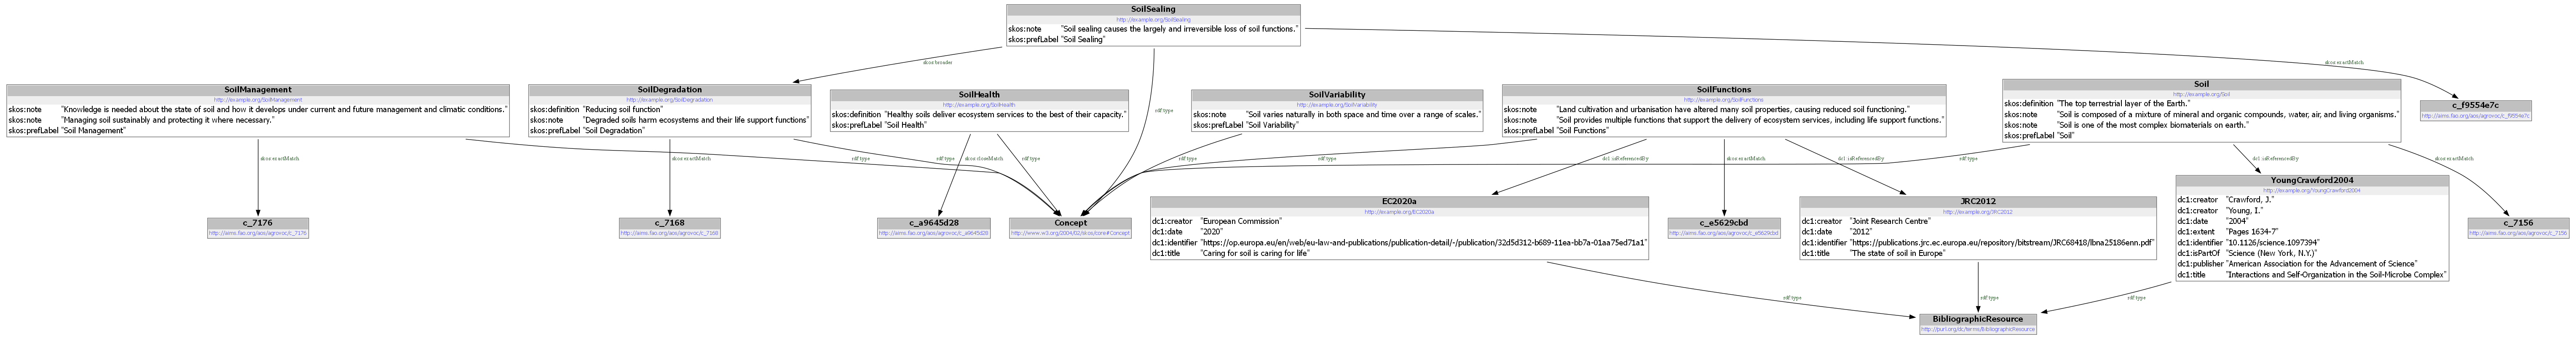

In [350]:
visualize(merged_graph)

### Interlink to external databases: a Zenodo example

In [352]:
# Define the API endpoint URL
api_url = "https://zenodo.org/api/records"

# query for datasources with 'soil'
# get first 200 datasources
# loop through pages to retrieve next part of data
# only get sources with status published
#  options: https://developers.zenodo.org/?python#list36

# list to gather all data through API requests
zenodo_data = []

# loop through pages to retreive next part of data
for i in range(1,11):
    print(f'loop num {i}')
    params = {'q': 'soil',
              'size':'20',
              'page':f'{i}',
              'status':'published',
              'sort':'bestmatch',
              'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url,params = params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        zenodo_data = zenodo_data + data['hits']['hits']
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    
zenodo_data

loop num 1
loop num 2
loop num 3
loop num 4
loop num 5
loop num 6
loop num 7
loop num 8
loop num 9
loop num 10


[{'created': '2021-08-05T16:06:00.842433+00:00',
  'modified': '2021-08-06T01:48:27.870247+00:00',
  'id': 5159133,
  'conceptrecid': '5159132',
  'doi': '10.5281/zenodo.5159133',
  'conceptdoi': '10.5281/zenodo.5159132',
  'doi_url': 'https://doi.org/10.5281/zenodo.5159133',
  'metadata': {'title': 'Soil Survey of Scotland Staff (1970-1987). Soil maps of Scotland (partial coverage) at a scale of 1:25 000. Digital phase 8 release.',
   'doi': '10.5281/zenodo.5159133',
   'publication_date': '2021-08-04',
   'description': '<p>This is the digital dataset which was created by digitising the Soils of Scotland 1:25,000 Soil maps and the Soils of Scotland 1:25,000 Dyeline Masters. The Soils of Scotland 1:25,000 Soil maps were the source documents for the production of the Soils of Scotland 1:63,360 and 1:50,000 published map series. Where no 1:25,000 published maps exist 1:63,360 maps have been digitised for this data set, the field SOURCE_MAP describes the source of the data. The classific

In [354]:
# gather the id's in list to then extract data directly as dublincore representation
id_list = []
for i in range(0,len(zenodo_data)):
    id_list.append(zenodo_data[i]['id'])

In [356]:
# Convert HTML to plain text
class CleanHTML(HTMLParser):
    def reset(self) -> None:
        self.extracted_data = ""
        return super().reset()

    def remove_tags(self, html_data: str) -> str:
        """
        Args:
            html_data (str): HTML data which might contain tags.

        Returns:
            str: Data without any HTML tags. Forces feeding of any buffered data.
        """
        self.reset()
        self.feed(html_data)
        self.close()
        return self.extracted_data

    def handle_data(self, data: str) -> None:
        """
        Args:
            data (str): Html data extracted from tags to be processed.
        """
        self.extracted_data += data

p = CleanHTML()

In [389]:
# Extract DublinCore standardized metadata and generate json with all data
zenodo_dc_data = {}
for i in range(len(id_list)):

    # Define the API endpoint URL
    api_url = f"https://zenodo.org/records/{id_list[i]}/export/dublincore"
    params = {'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url,params = params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        try:
            # Parse the XML response
            root = ET.fromstring(response.content)

            # Define expected tags with namespace
            expected_tags = {
                "{http://purl.org/dc/elements/1.1/}creator": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}subject": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}date": None,         # Initialize as None
                "{http://purl.org/dc/elements/1.1/}title": None,        # Initialize as None
                "{http://purl.org/dc/elements/1.1/}description": None,   # Initialize as None
                "{http://purl.org/dc/elements/1.1/}identifier": None,    # Initialize as None
                "{http://purl.org/dc/elements/1.1/}language": None    # Initialize as None
            }

            # Create a dictionary for JSON conversion
            json_dict = {}

            # Check if the root has child elements
            if root:
                for child in root:
                    # Get full tag name, preserving namespace
                    tag = child.tag
                    text = p.remove_tags(unescape(child.text))  # Convert HTML entities to normal text


                    if tag in expected_tags:
                        if "creator" in tag or "subject" in tag:
                            if "creator" in tag:
                                if json_dict.get(tag) is None:
                                    json_dict[tag] = [text]
                                else:
                                    json_dict[tag].append(text)
                            elif "subject" in tag:
                                # Split subjects by comma and strip spaces
                                
                                subjects = [subj.strip() for subj in re.split(r'[;,]', text)]
                                if json_dict.get(tag) is None:
                                    json_dict[tag] = subjects
                                else:
                                    json_dict[tag].extend(subjects)
                        else:
                            if json_dict.get(tag) is None:
                                json_dict[tag] = text  # Directly store as a string for date, title, description and identifier

                # Ensure all expected tags are included in the json_dict
                for tag, value in expected_tags.items():
                    if tag not in json_dict:
                        json_dict[tag] = value

                output_dict = {}
                # Adjusting the output to match the "dc:" prefix requirement
                for key, value in json_dict.items():
                    adjusted_key = key.split('}')[-1]  # Remove namespace URI
                    output_dict["dc:" + adjusted_key] = value

                zenodo_dict={
                    i:output_dict
                }
                
                #add to general json
                zenodo_dc_data.update(zenodo_dict)
            
            else:
                print("No repositories found in the response.")
        except ET.ParseError:
            print("Error: Unable to parse XML content.")
    else:
        # Print an error message if the request was not successful
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        print(response.text)

zenodo_dc_data

{0: {'dc:creator': ['Soil Survey Staff'],
  'dc:date': '2021-08-04',
  'dc:description': "This is the digital dataset which was created by digitising the Soils of Scotland 1:25,000 Soil maps and the Soils of Scotland 1:25,000 Dyeline Masters. The Soils of Scotland 1:25,000 Soil maps were the source documents for the production of the Soils of Scotland 1:63,360 and 1:50,000 published map series. Where no 1:25,000 published maps exist 1:63,360 maps have been digitised for this data set, the field SOURCE_MAP describes the source of the data. The classification is based on Soil Associations, Soil Series and Phases which reflect parent material, major soil group, and soil sub-groups, drainage and (for phases), texture, stoniness, land use, rockiness, topography and organic matter. Phases are not always mapped. In general terms this dataset primarily covers the cultivated land of Scotland but also includes some upland areas.\xa0 This data set is undergoing a phased revision, the latest (phas

In [435]:
# Convert metadata to RDF statements
# Dictionary of metadata entries, indexed by a unique key
metadata_entries = zenodo_dc_data

# Fill in all the missing keywords under named graph "generated"
# Create a ConjunctiveGraph to store quads
g_zenodo_extend = ConjunctiveGraph()

# Define named graphs
metadata_graph = URIRef("http://example.org/metadata")
generated_graph = URIRef("http://example.org/generated")

# keywords generation
def generate_subjects(text):
    # Placeholder function to simulate generating subjects based on the title
    kw_model = KeyBERT()
    seed_keywords = ["soil"]

    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words=None, seed_keywords=seed_keywords, use_mmr=True, diversity=0.5)
    keywords = [item[0] for item in keywords if item[1] > 0.5]
    
    return keywords

# Loop through each metadata entry
for entry_id, metadata in metadata_entries.items():
    if metadata['dc:language'] is None or metadata['dc:language'] == 'eng': 
        # Define the URI for the resource using its identifier
        resource_uri = URIRef(metadata['dc:identifier'])

        # Define the resource as a BibliographicResource
        g_zenodo_extend.add((resource_uri, RDF.type, DCTERMS.BibliographicResource, metadata_graph))
    
        # Add the title, date, and identifier
        g_zenodo_extend.add((resource_uri, DCTERMS.title, Literal(metadata['dc:title']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.date, Literal(metadata['dc:date']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.identifier, URIRef(metadata['dc:identifier']), metadata_graph))

        # Add creators, which can have multiple values
        for creator in metadata['dc:creator']:
            g_zenodo_extend.add((resource_uri, DCTERMS.creator, Literal(creator), metadata_graph))
    
        # Check if subjects are provided, otherwise generate them
        if metadata['dc:subject'] is None:
            generated_subjects = generate_subjects(f"{metadata['dc:title']}. {metadata['dc:description']}")
            for subject in generated_subjects:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject), generated_graph))
        else:
            for subject in metadata['dc:subject']:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject.strip()), metadata_graph))

# Output the graph in Turtle format
print(g_zenodo_extend.serialize(format="trig"))

@prefix dcterms: <http://purl.org/dc/terms/> .

<http://example.org/metadata> {
    <https://doi.org/10.1007/s11119-021-09805-y> a dcterms:BibliographicResource ;
        dcterms:creator "Blagojević, Dragana",
            "Dedović, Nebojša",
            "Ivošević, Bojana",
            "Kostić, Marko",
            "Ljubičić, Nataša",
            "Radulović, Mirjana",
            "Rajković, Miloš" ;
        dcterms:date "2021-04-11" ;
        dcterms:identifier <https://doi.org/10.1007/s11119-021-09805-y> ;
        dcterms:subject "Central composite design",
            "On-the-go measurement",
            "Sensors",
            "Soil properties" ;
        dcterms:title "Georeferenced tractor wheel slip data for prediction of spatial variability in soil physical properties" .

    <https://doi.org/10.1016/j.foreco.2022.120637> a dcterms:BibliographicResource ;
        dcterms:creator "Abramoff, Rose",
            "Adamczyk, Bartosz",
            "Baldy, Virginie",
            "Biryol, Ch

In [431]:
# Interlink metadata quads with soil health knowledge graph
# Utility function to split PascalCase into separate words
def split_pascal_case(s):
    return ' '.join(re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', s))

# Function to link concepts
def link_concepts(graph, concept_graph):
    # Extract all concept and conceptScheme URIs and labels
    labels = {}
    for concept_type in [SKOS.Concept, SKOS.ConceptScheme]:
        for c in concept_graph.subjects(RDF.type, concept_type):
            pref_label = concept_graph.value(c, SKOS.prefLabel)
            # Additionally save split PascalCase label
            pascal_split_label = split_pascal_case(c.split('/')[-1]).lower()
            labels[c] = [pref_label.lower() if pref_label else "", pascal_split_label]

    for s, p, o, g in graph.quads((None, None, None, None)):
        subject_label = o.lower()
        for c, label_list in labels.items():
            if subject_label in label_list:
                graph.remove((s, p, o, g))
                graph.add((s, p, c, g))  # Preserve original predicate
                concept_graph.add((c, DCTERMS.isReferencedBy, s))

# Link concepts between metadata and concept graphs
link_concepts(g_zenodo_extend, merged_graph)

# Serialize the graphs to check the output
print("Concept Graph:")
print(merged_graph.serialize(format='turtle'))

Concept Graph:
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc1: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

ex:EC2020a a dc1:BibliographicResource ;
    dc1:creator "European Commission" ;
    dc1:date "2020" ;
    dc1:identifier "https://op.europa.eu/en/web/eu-law-and-publications/publication-detail/-/publication/32d5d312-b689-11ea-bb7a-01aa75ed71a1" ;
    dc1:title "Caring for soil is caring for life" .

ex:JRC2012 a dc1:BibliographicResource ;
    dc1:creator "Joint Research Centre" ;
    dc1:date "2012" ;
    dc1:identifier "https://publications.jrc.ec.europa.eu/repository/bitstream/JRC68418/lbna25186enn.pdf" ;
    dc1:title "The state of soil in Europe" .

ex:Soil a skos:Concept ;
    dc1:isReferencedBy ex:Soil,
        ex:YoungCrawford2004,
        <https://doi.org/10.5281/zenodo.1131349>,
        <https://doi.org/10.5281/zenodo.5159133>,
        <https://doi.org/10.5281/zenodo.6921102

In [397]:
print("Metadata Graph:")
print(g_zenodo_extend.serialize(format='trig'))

Metadata Graph:
@prefix dcterms: <http://purl.org/dc/terms/> .

<http://example.org/metadata> {
    <https://doi.org/10.1007/s11119-021-09805-y> a dcterms:BibliographicResource ;
        dcterms:creator "Blagojević, Dragana",
            "Dedović, Nebojša",
            "Ivošević, Bojana",
            "Kostić, Marko",
            "Ljubičić, Nataša",
            "Radulović, Mirjana",
            "Rajković, Miloš" ;
        dcterms:date "2021-04-11" ;
        dcterms:identifier <https://doi.org/10.1007/s11119-021-09805-y> ;
        dcterms:subject "Central composite design",
            "On-the-go measurement",
            "Sensors",
            "Soil properties" ;
        dcterms:title "Georeferenced tractor wheel slip data for prediction of spatial variability in soil physical properties" .

    <https://doi.org/10.1016/j.foreco.2022.120637> a dcterms:BibliographicResource ;
        dcterms:creator "Abramoff, Rose",
            "Adamczyk, Bartosz",
            "Baldy, Virginie",
       

In [433]:
#Store soil health triples in the named graph called "concept"
concept_graph = URIRef("http://example.org/concept")

concept_graph_extended = g_zenodo_extend
for s, p, o in merged_graph:
    concept_graph_extended.add((s, p, o, concept_graph))

example = Namespace("http://example.org/")
agrovoc = Namespace("http://aims.fao.org/aos/agrovoc/")

concept_graph_extended.bind("ex", example)
concept_graph_extended.bind("agrovoc", agrovoc)
concept_graph_extended.bind("skos", SKOS)

print(concept_graph_extended.serialize(format='trig'))
# Save the graph to a file
concept_graph_extended.serialize(destination="example_soil_health_KG.trig", format="trig")

@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

ex:metadata {
    <https://doi.org/10.1007/s11119-021-09805-y> a dcterms:BibliographicResource ;
        dcterms:creator "Blagojević, Dragana",
            "Dedović, Nebojša",
            "Ivošević, Bojana",
            "Kostić, Marko",
            "Ljubičić, Nataša",
            "Radulović, Mirjana",
            "Rajković, Miloš" ;
        dcterms:date "2021-04-11" ;
        dcterms:identifier <https://doi.org/10.1007/s11119-021-09805-y> ;
        dcterms:subject "Central composite design",
            "On-the-go measurement",
            "Sensors",
            "Soil properties" ;
        dcterms:title "Georeferenced tractor wheel slip data for prediction of spatial variability in soil physical properties" .

    <https://doi.org/10.1016/j.foreco.2022.120637> a dcterms:BibliographicResource ;
  

<Graph identifier=N41ce60332f3e4ccd903893fa12007fff (<class 'rdflib.graph.ConjunctiveGraph'>)>

### Validate the (extended) knowledge graph by question answering (with NLQ)

In [417]:
graph = RdfGraph(
    source_file="example_soil_health_KG.ttl",
    serialization="ttl",
    standard="rdf",
)

In [419]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)
chain = GraphSparqlQAChain.from_llm(llm=llm, graph=graph, return_sparql_query=True, verbose=True)

In [421]:
graph.get_schema

'In the following, each IRI is followed by the local name and optionally its description in parentheses. \nThe RDF graph supports the following node types:\n<http://purl.org/dc/terms/BibliographicResource> (BibliographicResource, None), <http://www.w3.org/2004/02/skos/core#ConceptScheme> (ConceptScheme, None), <http://www.w3.org/2004/02/skos/core#Concept> (Concept, None)\nThe RDF graph supports the following relationships:\n<http://purl.org/dc/terms/subject> (subject, None), <http://purl.org/dc/terms/creator> (creator, None), <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> (type, None), <http://purl.org/dc/terms/identifier> (identifier, None), <http://example.org/autoSubject> (autoSubject, None), <http://purl.org/dc/terms/title> (title, None), <http://purl.org/dc/terms/date> (date, None), <http://purl.org/dc/terms/isReferencedBy> (isReferencedBy, None), <http://www.w3.org/2004/02/skos/core#prefLabel> (prefLabel, None), <http://purl.org/dc/terms/publisher> (publisher, None), <http://w

In [427]:
result = chain.invoke("""
    what is soil?

    Please generate case insensitive SPARQL query for string match.  
    Please only generate the pure SPARQL query without any comments or '```'.
    Please only output the Final answer without the SPARQL query. Thank you!
""")

print(f"Final answer: {result['result']}")



> Entering new GraphSparqlQAChain chain...
Identified intent:
SELECT
Generated SPARQL:
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?definition
WHERE {
    ?concept skos:prefLabel ?label .
    FILTER (lcase(?label) = "soil") .
    ?concept skos:definition ?definition .
}
Full Context:
[(rdflib.term.Literal('The top terrestrial layer of the Earth.'),)]

> Finished chain.
Final answer: Soil is the top terrestrial layer of the Earth.


In [429]:
query = result['sparql_query']

# Execute the query
for row in graph.query(query):
    print(f"{row.definition}")

The top terrestrial layer of the Earth.
